In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, roc_auc_score, recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import shap

In [41]:
viewership_df = pd.read_csv('Datasets/viewership_data.csv')
sub = pd.read_csv('Datasets/subs_data.csv')

train_start, train_end = '2024-01-01','2024-06-30'
val_start, val_end = '2024-07-01','2024-12-31'
seed = 2

### Viewership Preprocessing

In [42]:
# Ensure the time columns are in datetime format
viewership_df['Time Started'] = pd.to_datetime(viewership_df['Time Started'])
viewership_df['Time Ended'] = pd.to_datetime(viewership_df['Time Ended'])

# Calculate watch time for each entry
viewership_df['Watch Minutes'] = (viewership_df['Time Ended'] - viewership_df['Time Started']).dt.total_seconds() / 60 

# filter Watch Minutes >= 6 mins
viewership_df = viewership_df[viewership_df['Watch Minutes'] >= 6]
viewership_df['Month'] = viewership_df['Time Started'].dt.month

In [43]:
def aggregate_viewership_monthly(
    df: pd.DataFrame,
    id_col: str = "Capstone_id",
    start_month: int = 1,
    end_month: int = 6
):
    """
    Aggregate raw viewership into monthly features per user.

    Parameters
    ----------
    df : pd.DataFrame
    id_col : str
    start_month : int
    end_month : int

    Returns
    -------
    pd.DataFrame
        Columns:
          - id_col
          - "Month" (int)
          - "total_watch_minutes" (sum of Watch Minutes)
          - "frequency" (session count)
          - "unique_shows" (# distinct Show Name)
          - "avg_session_minutes" (mean Watch Minutes)
          - "top_network" (mode of Network)
          - "top_genre" (mode of Genre)
        One row per (user, month) in the [start_month…end_month] range;
        missing months are filled with zeros/empty strings.
    """
    
    df = df.copy()
    df = df[df["Month"].between(start_month, end_month)]

    # group and compute all aggregations at once
    grp = df.groupby([id_col, "Month"])
    agg = grp.agg(
        total_watch_minutes = ("Watch Minutes", "sum"),
        avg_session_minutes= ("Watch Minutes", "mean"),
        frequency          = ("Show Name",     "count"),
        unique_shows       = ("Show Name",     "nunique"),
        top_network        = ("Network",       lambda x: x.value_counts().idxmax()),
        top_genre          = ("Genre",         lambda x: x.value_counts().idxmax()),
    ).reset_index()

    # reindex to ensure every user has all months
    users = df[id_col].unique()
    months = list(range(start_month, end_month + 1))
    full_idx = pd.MultiIndex.from_product([users, months], names=[id_col, "Month"])

    agg = (
        agg
        .set_index([id_col, "Month"])
        .reindex(full_idx)
        .fillna({
            "total_watch_minutes": 0,
            "frequency": 0,
            "unique_shows": 0,
            "avg_session_minutes": 0,
            "top_network": "",
            "top_genre": ""
        })
        .reset_index()
    )

    return agg

In [95]:
view_monthly = aggregate_viewership_monthly(viewership_df, "Capstone_id", 1, 6)
view_monthly.head(18)

,Capstone_id,Month,total_watch_minutes,avg_session_minutes,frequency,unique_shows,top_network,top_genre
0,HKH9549865,1,100.0,100.000000,1.0,1.0,Pulse,Adventure
1,HKH9549865,2,0.0,0.000000,0.0,0.0,,
2,HKH9549865,3,0.0,0.000000,0.0,0.0,,
3,HKH9549865,4,78.0,78.000000,1.0,1.0,KidsZone,Kids
4,HKH9549865,5,119.0,119.000000,1.0,1.0,Pulse,Adventure
5,HKH9549865,6,0.0,0.000000,0.0,0.0,,
6,ABN4397549,1,123.0,30.750000,4.0,4.0,Lime Light,Reality TV
7,ABN4397549,2,114.0,114.000000,1.0,1.0,Pulse,Thriller
8,ABN4397549,3,86.0,86.000000,1.0,1.0,Lime Light,Reality TV
9,ABN4397549,4,37.0,37.000000,1.0,1.0,HeartStream,Romance


### Subscription Preprocessing

In [14]:
sub_filtered = sub[sub['SUB_START']<='2024-06-30']

sub_filtered['SUB_START'] = pd.to_datetime(sub_filtered['SUB_START'])
sub_filtered['SUB_END'] = pd.to_datetime(sub_filtered['SUB_END'])
cutoff_date = pd.to_datetime('2024-06-30')

sub_filtered = sub_filtered.rename(columns={'RECENCY':'total_recency'})
sub_filtered['recency'] = (sub_filtered[['SUB_END']].apply(lambda x: min(x[0], cutoff_date), axis=1) - sub_filtered['SUB_START']).dt.days

/var/folders/c6/jdy754rj7hj2s72qsv0132k00000gn/T/ipykernel_97278/3540223993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered['SUB_START'] = pd.to_datetime(sub_filtered['SUB_START'])
/var/folders/c6/jdy754rj7hj2s72qsv0132k00000gn/T/ipykernel_97278/3540223993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered['SUB_END'] = pd.to_datetime(sub_filtered['SUB_END'])
/var/folders/c6/jdy754rj7hj2s72qsv0132k00000gn/T/ipykernel_97278/3540223993.py:7: FutureWarning: Series.__getitem__ trea

,total_recency,SUB_START,SUB_END,FREQUENCY,CURRENT_TERM,MONETARY,REVENUE,RESUBSCRIBER,BRAND,Capstone_id,recency
0,7,2024-02-27,2024-03-05,1,monthly,11.99,143.88,0,PULSE,ETM3560501,7
3,32,2024-02-01,2024-03-04,1,monthly,11.99,143.88,0,PULSE,ZLE5622372,32
4,137,2024-05-17,2024-10-01,1,monthly,11.99,143.88,0,PULSE,RAJ3140438,44
5,32,2024-02-01,2024-03-04,1,annual,86.88,86.88,0,PULSE,PPZ7199683,32
6,106,2024-02-01,2024-05-17,1,monthly,11.99,143.88,0,PULSE,PAO4909132,106


In [15]:
# Calculate total duration based on CURRENT_TERM
sub_filtered["term_num"] = sub_filtered.apply(
    lambda row: np.ceil(row["total_recency"] / 30) if row["CURRENT_TERM"] == "monthly" else
                np.ceil(row["total_recency"] / 7) if row["CURRENT_TERM"] == "weekly" else
                np.ceil(row["total_recency"] / 365),  
    axis=1
)

# Compute total monetary value
sub_filtered["total_monetary"] = sub_filtered["term_num"] * sub_filtered["MONETARY"]

# Compute monetary value for first 6 months and last 6 months
sub_filtered['monetary_1'] = sub_filtered.apply(
    lambda row: round((row['recency']/row['total_recency'])*row['total_monetary'], 2), axis=1
)
sub_filtered['monetary_2'] = sub_filtered.apply(
    lambda row: round(row['total_monetary']-row['monetary_1'], 2), axis=1
)
sub_filtered[['total_recency', 'SUB_START', 'SUB_END', 'recency', 'monetary_1', 'monetary_2']]

,total_recency,SUB_START,SUB_END,recency,monetary_1,monetary_2
0,7,2024-02-27,2024-03-05,7,11.99,0.00
3,32,2024-02-01,2024-03-04,32,23.98,0.00
4,137,2024-05-17,2024-10-01,44,19.25,40.70
5,32,2024-02-01,2024-03-04,32,86.88,0.00
6,106,2024-02-01,2024-05-17,106,47.96,0.00
...,...,...,...,...,...,...
111662,274,2024-02-01,2024-11-01,150,54.69,45.21
111663,47,2024-04-01,2024-05-18,47,19.98,0.00
111665,144,2024-04-10,2024-09-01,81,25.28,19.67
111666,186,2024-05-17,2024-11-19,44,14.90,48.09


### LTV labeling

In [31]:
def perform_kmeans(data, columns, n_clusters, new_column_name):
    """
    Performs KMeans clustering and adds cluster labels to the dataframe.
    
    Parameters:
    - data: pandas DataFrame containing your data.
    - columns: list of column names to use for clustering.
    - n_clusters: number of clusters to form.
    - new_column_name: name of the new column to store cluster labels.
    
    Returns:
    - data: DataFrame with new cluster labels column.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    kmeans.fit(data[[columns]])
    data[new_column_name] = kmeans.predict(data[[columns]])
    return data

def order_cluster(cluster_field_name, target_field_name, df, ascending):
    """
    Sorting clusters 
    """
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df, df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [32]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(sub_filtered[['monetary_2']])
sub_filtered['LTV_cluster'] = kmeans.predict(sub_filtered[['monetary_2']])
sub_filtered = order_cluster('LTV_cluster', 'monetary_2', sub_filtered, True)
sub_filtered.groupby('LTV_cluster')['monetary_2'].describe()

/var/folders/c6/jdy754rj7hj2s72qsv0132k00000gn/T/ipykernel_97278/797808778.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_filtered['LTV_cluster'] = kmeans.predict(sub_filtered[['monetary_2']])


,count,mean,std,min,25%,50%,75%,max
LTV_cluster,,,,,,,,
0,55670.0,0.668621,2.833877,-0.00,0.0000,0.00,0.00,18.09
1,22372.0,35.630540,6.056509,18.19,33.0300,37.56,40.68,43.55
2,18558.0,51.470105,11.344538,43.56,47.8875,50.34,54.26,444.97


In [35]:
def aggregate_subscription_monthly(
    df: pd.DataFrame,
    id_col: str = "Capstone_id",
    start_month: int = 1,
    end_month: int = 6,
    year: int = 2024
) -> pd.DataFrame:
    """
    Turn raw subscription records into per-user, per-month features.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
          - id_col (e.g. "Capstone_id")
          - "SUB_START", "SUB_END" 
          - "MONETARY" (numeric fee)
          - "CURRENT_TERM" (e.g. "monthly" or "annual")
          - "BRAND" (categorical)
    id_col : str
        Name of the user-ID column.
    start_month, end_month : int
        Month window (1-12).
    year : int

    Returns
    -------
    pd.DataFrame
        One row per (user, month) in [start_month…end_month], with columns:
          - subscription_active  (0/1)
          - avg_monthly_fee      (float)
          - total_monthly_fee    (float)
          - most_common_brand    (str)
          - predominant_term     (str)
    """
    df = df.copy()

    # 1. Compute a monthly-equivalent fee
    df["monthly_fee"] = np.where(
        df["CURRENT_TERM"].str.lower() == "monthly",
        df["MONETARY"],
        df["MONETARY"] / 12
    )
    
    # 2. Expand each subscription to all months it covers
    df["start_ym"] = df["SUB_START"].dt.to_period("M")
    # if SUB_END is NaT (ongoing), treat as end of window
    df["end_ym"] = (
        df["SUB_END"]
        .dt.to_period("M")
        .fillna(pd.Period(f"{year}-{end_month:02}", freq="M"))
    )
    
    df = (
        df.assign(
            month_period=lambda d: d.apply(
                lambda row: pd.period_range(row["start_ym"], row["end_ym"], freq="M"),
                axis=1
            )
        )
        .explode("month_period")
    )
    
    # 3. Keep only target window (Jan–Jun 2024)
    df["year"]  = df["month_period"].dt.year
    df["month"] = df["month_period"].dt.month
    df = df[
        (df["year"] == year) &
        (df["month"].between(start_month, end_month))
    ]
    
    # 4. Group and aggregate
    grp = df.groupby([id_col, "month"])
    sub_agg = grp.agg(
        subscription_active = ("monthly_fee", lambda x: int(x.count() > 0)),
        avg_monthly_fee     = ("monthly_fee", "mean"),
        total_monthly_fee   = ("monthly_fee", "sum"),
        most_common_brand   = ("BRAND",   lambda x: x.value_counts().idxmax()),
        num_networks_subscribed   = ("BRAND",  lambda x: x.nunique()),
        predominant_term    = ("CURRENT_TERM", lambda x: x.value_counts().idxmax())
    ).reset_index()
    
    # 6. Reindex so every user+month appears
    users = df[id_col].unique()
    months = list(range(start_month, end_month + 1))
    full_idx = pd.MultiIndex.from_product([users, months], names=[id_col, "month"])
    
    sub_agg = (
        sub_agg
        .set_index([id_col, "month"])
        .reindex(full_idx)
        .fillna({
            "subscription_active": 0,
            "avg_monthly_fee": 0,
            "total_monthly_fee": 0,
            "most_common_brand": "",
            "num_networks_subscribed": 0,
            "predominant_term": ""
        })
        .reset_index()
    )
    
    return sub_agg

In [36]:
# get per-user, per-month features for Jan–Jun 2024
sub_monthly = aggregate_subscription_monthly(sub_filtered)

In [89]:
sub_monthly

,Capstone_id,month,subscription_active,avg_monthly_fee,total_monthly_fee,most_common_brand,num_networks_subscribed,predominant_term
0,ETM3560501,1,0.0,0.00,0.00,,0.0,
1,ETM3560501,2,1.0,11.99,11.99,PULSE,1.0,monthly
2,ETM3560501,3,1.0,11.99,11.99,PULSE,1.0,monthly
3,ETM3560501,4,0.0,0.00,0.00,,0.0,
4,ETM3560501,5,0.0,0.00,0.00,,0.0,
...,...,...,...,...,...,...,...,...
523045,UFH9300278,2,1.0,7.99,7.99,CINEQUEST,1.0,monthly
523046,UFH9300278,3,1.0,7.99,7.99,CINEQUEST,1.0,monthly
523047,UFH9300278,4,0.0,0.00,0.00,,0.0,
523048,UFH9300278,5,0.0,0.00,0.00,,0.0,


In [37]:
sub_monthly[sub_monthly.Capstone_id == 'RAJ3140438']

,Capstone_id,month,subscription_active,avg_monthly_fee,total_monthly_fee,most_common_brand,num_networks_subscribed,predominant_term
12,RAJ3140438,1,0.0,0.00,0.00,,0.0,
13,RAJ3140438,2,0.0,0.00,0.00,,0.0,
14,RAJ3140438,3,0.0,0.00,0.00,,0.0,
15,RAJ3140438,4,1.0,9.99,9.99,RETROREEL,1.0,monthly
16,RAJ3140438,5,1.0,10.99,21.98,PULSE,2.0,monthly
17,RAJ3140438,6,1.0,10.99,21.98,PULSE,2.0,monthly


### Prepare Bi-LSTM Model Inputs

In [90]:
def prepare_bilstm_input_onehot(
    view_df: pd.DataFrame,
    sub_df: pd.DataFrame,
    id_col: str = "Capstone_id",
    start_month: int = 1,
    end_month: int = 6,
    categorical_cols: list = None
) -> tuple:
    """
    Merge viewership and subscription monthly aggregates, one-hot encode specified
    categorical columns, and pivot into a 3D array for Bi-LSTM.

    Returns:
    - X: np.ndarray of shape (n_users, T, F)
    - user_ids: list of user identifiers in order
    - feature_cols: list of feature column names
    """
    # Align subscription month column name
    sub_df = sub_df.rename(columns={"month": "Month"})
    
    # Merge on id + Month
    merged = pd.merge(view_df, sub_df, on=[id_col, "Month"], how="right")
    
    # Fill missing values: numeric=0, categorical=''
    for col in merged.columns:
        if pd.api.types.is_numeric_dtype(merged[col]):
            merged[col] = merged[col].fillna(0)
        else:
            merged[col] = merged[col].fillna("")
    
    # Sort by user and month
    merged = merged.sort_values([id_col, "Month"])
    
    # One-hot encode specified categorical columns
    if categorical_cols is None:
        categorical_cols = ["top_network", "top_genre", "most_common_brand", "predominant_term"]
    merged = pd.get_dummies(merged, columns=categorical_cols, prefix_sep='_')
    
    # Extract users, time steps, and feature columns
    user_ids = merged[id_col].unique().tolist()
    T = end_month - start_month + 1
    feature_cols = [c for c in merged.columns if c not in [id_col, "Month"]]
    F = len(feature_cols)
    
    # Reshape into 3D array
    X = merged[feature_cols].values.reshape(len(user_ids), T, F)
    
    return merged, X, user_ids, feature_cols


In [91]:
merged, X, users, features = prepare_bilstm_input_onehot(view_monthly, sub_monthly)

In [93]:
X[0]

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, True,
        False, False, False, False, False, True, False, False],
       [0.0, 0.0, 0.0, 0.0, 1.0, 7.239999999999999, 7.239999999999999,
        1.0, True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, True, False,
        False, True, Fa

In [94]:
len(X[0])

6

In [68]:
ltv_df = sub_filtered[['Capstone_id', 'LTV_cluster']]

label_map = ltv_df.set_index("Capstone_id")["LTV_cluster"].to_dict()

y = np.array([ label_map.get(uid, np.nan) for uid in users ], dtype=int)

# check for any missing labels
missing = np.isnan(y).sum()
if missing:
    raise ValueError(f"{missing} users in X have no LTV_cluster in ltv_df")

In [70]:
# 60% train, 20% val, 20% test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, 
                                                 test_size=0.4, 
                                                 stratify=y,
                                                 random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, 
                                                test_size=0.5, 
                                                stratify=y_tmp,
                                                random_state=42)

### Bi-LSTM Model

In [98]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def build_bilstm_model(ts, d, k,
                       lstm_units=64, dropout_rate=0.2,
                       lr=1e-4, clipnorm=1.0):
    inp = Input((ts, d))
    x   = Bidirectional(LSTM(lstm_units, return_sequences=True))(inp)
    x   = Bidirectional(LSTM(lstm_units//2))(x)
    x   = BatchNormalization()(x)
    x   = Dense(64, activation="relu")(x)
    x   = Dropout(dropout_rate)(x)
    out = Dense(k, activation="softmax")(x)

    opt = Adam(learning_rate=lr, clipnorm=clipnorm)
    model = Model(inp, out)
    model.compile(
      optimizer=opt,
      loss="sparse_categorical_crossentropy",
      metrics=["accuracy"]
    )
    return model

#### BiLSTM-CNN Model

In [104]:
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, 
    Conv1D, MaxPooling1D, GlobalMaxPooling1D,
    BatchNormalization, Dense, Dropout
)

def build_bilstm_then_cnn(
    ts, d, k,
    lstm_units=64, 
    cnn_filters=64, kernel_size=3, pool_size=2,
    dropout_rate=0.2,
    lr=1e-4, clipnorm=1.0
):
    inp = Input(shape=(ts, d))
    
    # 1) two-layer BiLSTM (keep sequences)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(inp)
    x = Bidirectional(LSTM(lstm_units//2, return_sequences=True))(x)
    
    # 2) local pattern extraction on the LSTM’s outputs
    x = Conv1D(filters=cnn_filters,
               kernel_size=kernel_size,
               padding="same",
               activation="relu")(x)
    x = MaxPooling1D(pool_size=pool_size)(x)
    x = GlobalMaxPooling1D()(x)
    
    # 3) classification head
    x = BatchNormalization()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(k, activation="softmax")(x)
    
    opt = Adam(learning_rate=lr, clipnorm=clipnorm)
    model = Model(inp, out)
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [115]:
# model = build_bilstm_model(
#     X_train.shape[1], X_train.shape[2], 3,
#     lstm_units=128, dropout_rate=0.3, lr=5e-5
# )

model = build_bilstm_then_cnn(
    ts=X_train.shape[1],
    d=X_train.shape[2],
    k=3,
    lstm_units=128,
    cnn_filters=64,
    kernel_size=3,
    pool_size=2,
    dropout_rate=0.3,
    lr=5e-5
)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.39977, saving model to best_bilstm.h5


1635/1635 - 30s - 18ms/step - accuracy: 0.7652 - loss: 0.5533 - val_accuracy: 0.8449 - val_loss: 0.3998
Epoch 2/20

Epoch 2: val_loss improved from 0.39977 to 0.37304, saving model to best_bilstm.h5


1635/1635 - 28s - 17ms/step - accuracy: 0.8395 - loss: 0.4046 - val_accuracy: 0.8511 - val_loss: 0.3730
Epoch 3/20

Epoch 3: val_loss improved from 0.37304 to 0.36548, saving model to best_bilstm.h5


1635/1635 - 29s - 18ms/step - accuracy: 0.8529 - loss: 0.3795 - val_accuracy: 0.8593 - val_loss: 0.3655
Epoch 4/20

Epoch 4: val_loss improved from 0.36548 to 0.35442, saving model to best_bilstm.h5


1635/1635 - 28s - 17ms/step - accuracy: 0.8579 - loss: 0.3696 - val_accuracy: 0.8590 - val_loss: 0.3544
Epoch 5/20

Epoch 5: val_loss improved from 0.35442 to 0.34965, saving model to best_bilstm.h5


1635/1635 - 28s - 17ms/step - accuracy: 0.8604 - loss: 0.3615 - val_accuracy: 0.8642 - val_loss: 0.3496
Epoch 6/20

Epoch 6: val_loss did not improve from 0.34965
1635/1635 - 27s - 16ms/step - accuracy: 0.8633 - loss: 0.3548 - val_accuracy: 0.8597 - val_loss: 0.3550
Epoch 7/20

Epoch 7: val_loss improved from 0.34965 to 0.34724, saving model to best_bilstm.h5


1635/1635 - 27s - 17ms/step - accuracy: 0.8654 - loss: 0.3511 - val_accuracy: 0.8654 - val_loss: 0.3472
Epoch 8/20

Epoch 8: val_loss improved from 0.34724 to 0.34422, saving model to best_bilstm.h5


1635/1635 - 28s - 17ms/step - accuracy: 0.8672 - loss: 0.3454 - val_accuracy: 0.8702 - val_loss: 0.3442
Epoch 9/20

Epoch 9: val_loss improved from 0.34422 to 0.34394, saving model to best_bilstm.h5


1635/1635 - 27s - 17ms/step - accuracy: 0.8701 - loss: 0.3435 - val_accuracy: 0.8675 - val_loss: 0.3439
Epoch 10/20

Epoch 10: val_loss improved from 0.34394 to 0.33930, saving model to best_bilstm.h5


1635/1635 - 27s - 17ms/step - accuracy: 0.8704 - loss: 0.3422 - val_accuracy: 0.8700 - val_loss: 0.3393
Epoch 11/20

Epoch 11: val_loss improved from 0.33930 to 0.33808, saving model to best_bilstm.h5


1635/1635 - 27s - 17ms/step - accuracy: 0.8705 - loss: 0.3396 - val_accuracy: 0.8722 - val_loss: 0.3381
Epoch 12/20

Epoch 12: val_loss did not improve from 0.33808
1635/1635 - 27s - 17ms/step - accuracy: 0.8721 - loss: 0.3374 - val_accuracy: 0.8592 - val_loss: 0.3532
Epoch 13/20

Epoch 13: val_loss did not improve from 0.33808
1635/1635 - 28s - 17ms/step - accuracy: 0.8736 - loss: 0.3343 - val_accuracy: 0.8689 - val_loss: 0.3415
Epoch 14/20

Epoch 14: val_loss did not improve from 0.33808
1635/1635 - 28s - 17ms/step - accuracy: 0.8735 - loss: 0.3320 - val_accuracy: 0.8715 - val_loss: 0.3387
Epoch 15/20

Epoch 15: val_loss improved from 0.33808 to 0.33613, saving model to best_bilstm.h5


1635/1635 - 28s - 17ms/step - accuracy: 0.8743 - loss: 0.3309 - val_accuracy: 0.8720 - val_loss: 0.3361
Epoch 16/20

Epoch 16: val_loss did not improve from 0.33613
1635/1635 - 28s - 17ms/step - accuracy: 0.8750 - loss: 0.3301 - val_accuracy: 0.8726 - val_loss: 0.3364
Epoch 17/20

Epoch 17: val_loss did not improve from 0.33613
1635/1635 - 29s - 18ms/step - accuracy: 0.8766 - loss: 0.3269 - val_accuracy: 0.8729 - val_loss: 0.3420
Epoch 18/20

Epoch 18: val_loss did not improve from 0.33613
1635/1635 - 28s - 17ms/step - accuracy: 0.8765 - loss: 0.3270 - val_accuracy: 0.8739 - val_loss: 0.3378
Epoch 19/20

Epoch 19: val_loss improved from 0.33613 to 0.33372, saving model to best_bilstm.h5


1635/1635 - 28s - 17ms/step - accuracy: 0.8765 - loss: 0.3259 - val_accuracy: 0.8736 - val_loss: 0.3337
Epoch 20/20

Epoch 20: val_loss did not improve from 0.33372
1635/1635 - 27s - 17ms/step - accuracy: 0.8773 - loss: 0.3246 - val_accuracy: 0.8735 - val_loss: 0.3375
Restoring model weights from the end of the best epoch: 19.


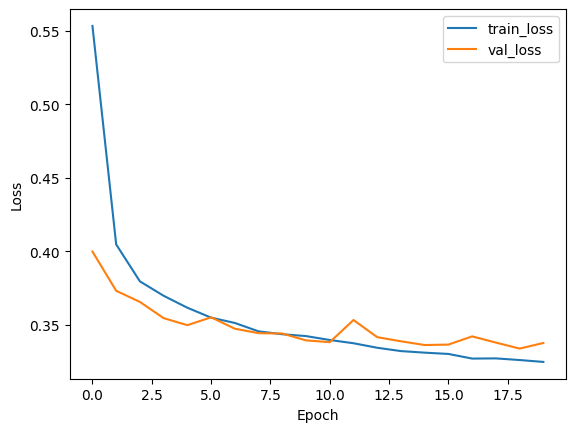

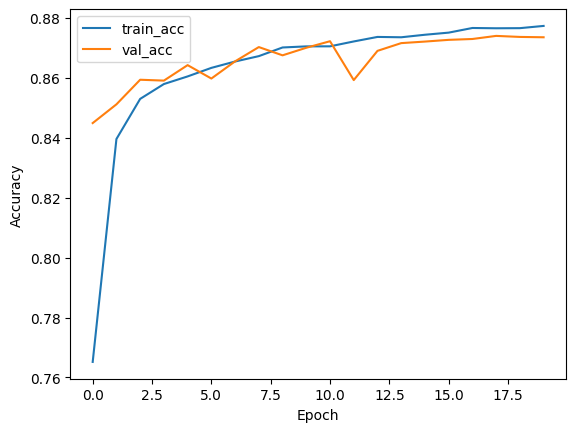

In [116]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# cast your inputs to the right types
X_train = X_train.astype("float32")
X_val   = X_val.astype("float32")
X_test  = X_test.astype("float32")

y_train = y_train.astype("int32")
y_val   = y_val.astype("int32")
y_test  = y_test.astype("int32")

batch_size  = 32
epochs      = 20

# 1. set up callbacks
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)
mc = ModelCheckpoint(
    "best_bilstm.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# 2. fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es, mc],
    verbose=2
)

# 3. inspect training curves
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Test Model Performances

In [117]:
# 1. Get predictions
y_pred_probs = model.predict(X_test)       
y_pred = y_pred_probs.argmax(axis=1)          # take the highest‑probability class

# 2. Print precision, recall, F1 for each class
print(classification_report(
    y_test,
    y_pred,
    digits=2
))

545/545 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     10124
           1       0.83      0.81      0.82      4018
           2       0.70      0.92      0.80      3293

    accuracy                           0.88     17435
   macro avg       0.84      0.87      0.85     17435
weighted avg       0.89      0.88      0.88     17435



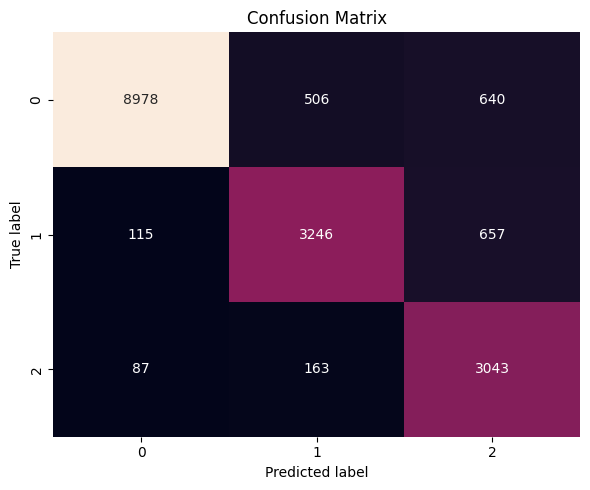

In [118]:
# 3. Build and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cbar=False
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### Feature Importance
Shuffle one feature (channel) at a time in validation set and see how much the metric degrades.

Permutation Importance measures the change in a model’s performance (e.g. accuracy, RMSE) when you randomly shuffle a single feature’s values, breaking its relationship to the target. If the score degrades substantially, that feature was important to the model

In [119]:
def permutation_importance(model, X_val, y_val, metric_fn):
    """
    model: a compiled Keras model
    X_val: [n_samples, ts, d]
    y_val: [n_samples,]
    metric_fn: e.g. lambda y_true, y_pred: accuracy_score(y_true, y_pred.argmax(-1))
    """
    # baseline performance
    y_pred = model.predict(X_val)
    base_score = metric_fn(y_val, y_pred)
    
    n_features = X_val.shape[-1]
    importances = []
    
    for feat in range(n_features):
        X_perm = X_val.copy()
        # shuffle the entire time-series for this channel
        for i in range(X_val.shape[0]):
            np.random.shuffle(X_perm[i,:,feat])
        
        y_pred_perm = model.predict(X_perm)
        perm_score = metric_fn(y_val, y_pred_perm)
        importances.append(base_score - perm_score)
    
    return np.array(importances)

# Usage example:
from sklearn.metrics import accuracy_score
imps = permutation_importance(model, X_val, y_val, lambda y,yp: accuracy_score(y, yp.argmax(-1)))
for idx, imp in enumerate(imps):
    print(f"Feature {idx}: Δacc = {imp:.4f}")


545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
545/545 ━━━━━━━━

In [120]:
def top_permutation_features(importances, feature_names, top_n=5):
    """
    importances : 1D array of length d, 
                  where importances[i] = Δmetric when feature i is shuffled
    feature_names: list of length d containing the name of each feature
    top_n        : how many top features to return
    """
    # sort features by descending importance
    sorted_idx = np.argsort(importances)[::-1]
    
    # pick the top N
    top_idx = sorted_idx[:top_n]
    
    return [(feature_names[i], importances[i]) for i in top_idx]

feature_names = list(merged.columns[2:])
top5 = top_permutation_features(imps, feature_names, top_n=5)
for name, delta in top5:
    print(f"{name:20s} → Δaccuracy = {delta:.4f}")


total_monthly_fee    → Δaccuracy = 0.1971
total_watch_minutes  → Δaccuracy = 0.1590
avg_session_minutes  → Δaccuracy = 0.1499
avg_monthly_fee      → Δaccuracy = 0.1378
predominant_term_annual → Δaccuracy = 0.0056
